In [1]:
import pandas as pd

#Loading Dataset
df = pd.read_csv("./datasets/legal_text_classification.csv")

In [2]:
def preprocess_data(df):
    #dropping Nan values
    df = df.dropna(subset=['case_text'])
    
    # Split the text samples into tokens and calculate the number of tokens in each text
    num_token = df['case_text'].str.split()
    token_count = num_token.apply(lambda x: len(x))
    
    #condition for selection
    X = df['case_text']
    under_510 = X[token_count <= 510].index
    over_510  = X[token_count > 510].index

    #removing case_text longer tha 510 token
    df_train = df.loc[under_510]
    df_test = df.loc[over_510]
    
    #dropping unused features
    df_train = df_train.drop(columns =['case_id', 'case_title'])
    df_train.rename(columns={"case_text":"text", "case_outcome":"label"}, inplace= True)
    
    df_test = df_test.drop(columns =['case_id', 'case_title'])
    df_test.rename(columns={"case_text":"text", "case_outcome":"label"}, inplace= True)
    
    # Get the number of unique labels
    labels_list = df_train["label"].unique().tolist()
    
    return df_train, df_test, labels_list
    

In [3]:
#splitting in training and test set
from datasets import Dataset, ClassLabel

#preprocessing dataset
df_train, df_test, labels_list = preprocess_data(df)

# Convert the DataFrame into a Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Dividing in train and test
train_valid = train_dataset.train_test_split(test_size=0.2)
print(train_valid)
train_valid

train = train_valid["train"]
valid = train_valid["test"]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 15882
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 3971
    })
})


In [4]:
import time
from transformers import AutoModel, AutoTokenizer
import torch
from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from sklearn.metrics import f1_score

In [20]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1": f1}

def legalbert_last_hiddenstate_fe(data, label_list):
    
    # Transformer settings
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'GPU on: {torch.cuda.is_available()}')
    model_ckpt= 'nlpaueb/legal-bert-small-uncased'
    trained_model = './tmp/run-10/checkpoint-11500'
    
    # Loading model and tokenaizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    model = AutoModel.from_pretrained(model_ckpt, num_labels = len(labels_list)).to(device)
    
    print("GPU memory allocated before tokenization", torch.cuda.memory_allocated()/(1024**3))
    

    
    #tokenizing samples
    def tokenization(sample):
        # Obtain unique label
        
        #tokenize text
        tokenized_sample = tokenizer(sample['text'], padding=True, truncation=True, max_length=512, return_tensors= "pt").to(device)
        
        #encode label
        labels = ClassLabel(names=labels_list)
        #tokenized_sample["label"] = labels.str2int(sample['label']) -> non funziona più non so perchè.
        print(tokenized_sample)
        return tokenized_sample
    
    
    data_token = data.map(tokenization, batched=True)
    print("Done tokenization")
    print("GPU memory allocated after tokenization", torch.cuda.memory_allocated()/(1024**3))
    torch.cuda.empty_cache()
    
    
    #mapping inputs
    def extract_hidden_state(batch, device = "cpu"):
        model.to("cpu")
        inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
        # Retriving last hidden state
        with torch.no_grad():
            last_hidden_state = model(**inputs).last_hidden_state
        
        return {"hidden_state": last_hidden_state[:,0]}
    
    
    data_token.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    
    data_hidden = data_token.map(extract_hidden_state, batched = True)
    
    print("Done hidden state")
    
    return data_hidden

In [21]:
# Record the start time
start_time = time.time()

# Call your function
train = legalbert_last_hiddenstate_fe(train, labels_list)
valid = legalbert_last_hiddenstate_fe(valid, labels_list)

# Record the end time
end_time = time.time()

execution_time = (end_time - start_time)/60

# Saving model info
#head_model = ""

#file_path = f'./models/legalbert_eurlex_{head_model}.txt'

#with open(file_path, 'w') as file:
    # Write data to the file
 #   file.write(f"{file:}\n")
  #  file.write(f"Execution Time: {execution_time} seconds\n")
   # file.write(f"List of all Labels: {labels_list}\n")


print("Execution Time:", execution_time, "minutes")

GPU on: True
GPU memory allocated before tokenization 0.41651344299316406


Map:   0%|          | 0/15882 [00:00<?, ? examples/s]

{'input_ids': tensor([[  101,   207, 12004,  ...,     0,     0,     0],
        [  101,  1067,   223,  ...,     0,     0,     0],
        [  101,   213,  1357,  ...,     0,     0,     0],
        ...,
        [  101,   247,   227,  ...,     0,     0,     0],
        [  101,   820,  1399,  ...,     0,     0,     0],
        [  101,   272,   385,  ...,   207,  1026,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}
{'input_ids': tensor([[ 101,  207, 1421,  ...,    0,    0,    0],
        [ 101,  213, 9308,  ...,

{'input_ids': tensor([[  101,   213,   270,  ...,   219,   484,   102],
        [  101,   207,   507,  ...,     0,     0,     0],
        [  101,  1558,  1041,  ...,     0,     0,     0],
        ...,
        [  101,   213, 13725,  ...,     0,     0,     0],
        [  101,   207,   352,  ...,     0,     0,     0],
        [  101,  5404,   207,  ...,     0,     0,     0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}
{'input_ids': tensor([[ 101,  207,  530,  ...,    0,    0,    0],
        [ 101, 1599, 9328,  ...,

Map:   0%|          | 0/15882 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [24]:
import numpy as np

#creating a features matrix
x_train = np.array(train["hidden_state"])
x_valid = np.array(valid["hidden_state"])
y_train = np.array(train["label"])
y_valid = np.array(valid["label"])

[[ 0.2971604   0.96638054  0.1651399  ... -1.2492964  -0.04392135
  -4.735369  ]
 [ 0.3640659   0.04319356 -1.4895798  ... -0.9107494  -0.57276356
  -6.2952847 ]
 [-0.9146846  -0.07635465 -1.4424157  ... -0.7501757  -1.7529038
  -5.593491  ]
 ...
 [-0.508013    1.1839051  -1.3346763  ... -0.96771616 -1.075715
  -6.3001575 ]
 [ 0.4913099   0.20549619 -1.2222755  ... -0.6051779  -0.21587703
  -5.2237415 ]
 [ 0.51676667 -0.06471787 -0.7117955  ... -0.645015    0.12950182
  -4.128287  ]]
[0 1 5 ... 0 0 1]


In [8]:
from sklearn.linear_model import LogisticRegression

# training softmax regression
clf = LogisticRegression(random_state=0, multi_class="multinomial").fit(x_train, y_train)
y_pred = clf.predict(x_valid)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


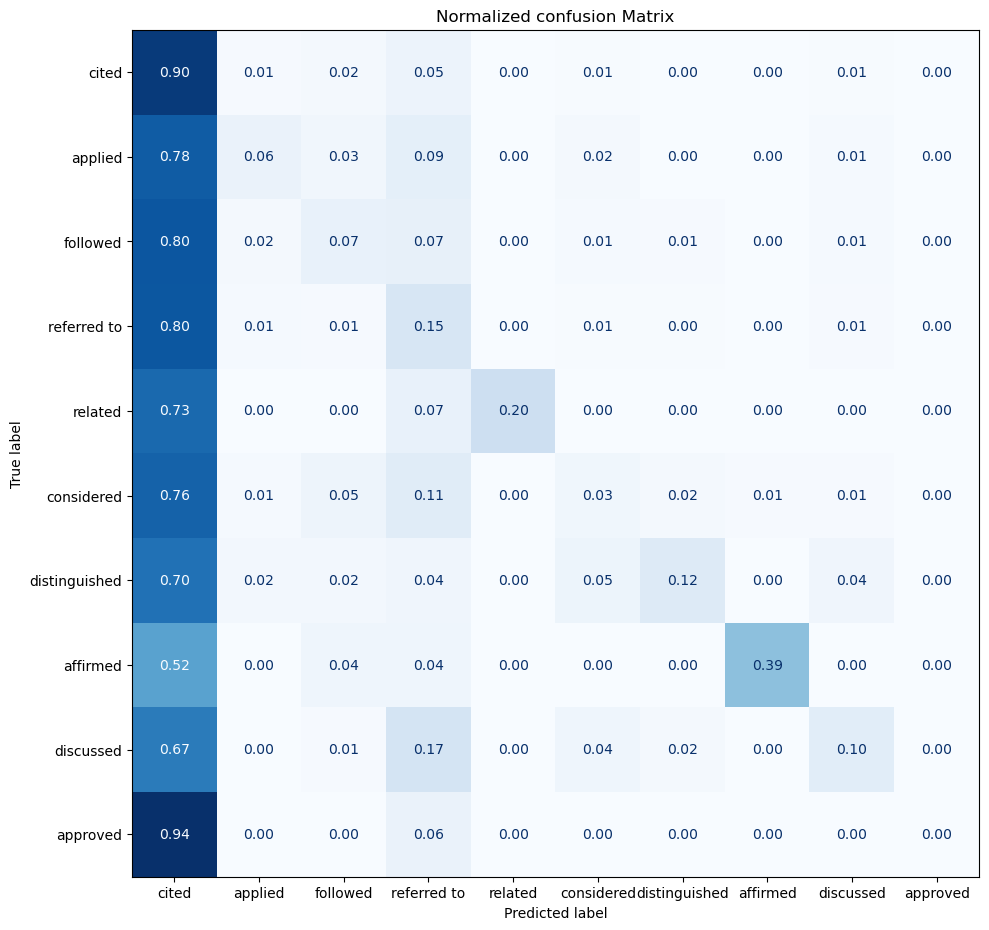

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

#confusion matrix
def plot_confusion_matrix(y_pred, y_true, labels_list):
    cm = confusion_matrix(y_true, y_pred, normalize= "true")
    fig, ax = plt.subplots(figsize=(11,11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels_list)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar= False)
    plt.title("Normalized confusion Matrix")
    plt.show()

# Confusion Matrix plot
plot_confusion_matrix(y_pred, y_valid, labels_list)